<a href="https://colab.research.google.com/github/gauss5930/Deep-Learning-Paper/blob/main/Multimodal%20Models/FLAVA/Interacting%20with%20FLAVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FLAVA 사용해보기

FLAVA 모델을 어떻게 다운로드하고 실행하는지 보여줄 것이다. 간략하게 설명하자면, 이미지와 텍스트 쌍의 유사도를 계산해보거나, zero-shot 이미지 분류를 수행해볼 것이다!! 😉

이 코드는 [여기](https://github.com/apsdehal/flava-tutorials)를 참고하여 작성되었다.

In [1]:
! pip install transformers
! pip install scikit-image

import numpy as np
import torch
from pkg_resources import packaging

print('Torch version: ', torch.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Torch version:  2.0.0+cu118


## model 불러오기

transformer 패키지로부터 FLAVA model을 다운로드하고 모델의 인스턴스 알아보기

In [2]:
from transformers import FlavaModel, FlavaFeatureExtractor, BertTokenizer

flava = FlavaModel.from_pretrained('facebook/flava-full')
fe = FlavaFeatureExtractor.from_pretrained('facebook/flava-full')
tokenizer = BertTokenizer.from_pretrained('facebook/flava-full')

flava = flava.cuda().eval()   # GPU 가속기를 사용해야 함.
input_resolution = flava.config.image_config.image_size
context_length = 77
vocab_size = flava.config.text_config.vocab_size

print('Model parameters: ', f"{np.sum([int(np.prod(p.shape)) for p in flava.parameters()]):,}")
print('Input resolution: ', input_resolution)
print('Context length: ', context_length)
print('Vocab_size: ', vocab_size)

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.


Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['mmm_image_head.transform.LayerNorm.weight', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_4.bias', 'image_codebook.blocks.group_3.group.block_2.res_path.path.conv_4.weight', 'mmm_image_head.transform.LayerNorm.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_3.weight', 'mmm_image_head.transform.dense.weight', 'mmm_text_head.decoder.bias', 'mmm_text_head.transform.dense.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_3.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_1.bias', 'image_codebook.blocks.group_3.group.block_1.id_path.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_2.bias', 'image_codebook.blocks.group_2.group.block_2.res_path.path.conv_4.bias', 'image_codebook.blocks.group_2.group.block_1.id_path.bias', 'image_codebook.blocks.group_4.group.block_1.id_path.weight', '

/usr/local/lib/python3.9/dist-packages/transformers/models/flava/feature_extraction_flava.py:28: FutureWarning: The class FlavaFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use FlavaImageProcessor instead.
  warnings.warn(


Model parameters:  241,356,289
Input resolution:  224
Context length:  77
Vocab_size:  30522


## 이미지 전처리

입력 이미지의 크기를 변경하고 center-crop해서 모델이 예상하는 이미지 해상도에 따른다. 이를 하기 전에, 데이터셋의 평균과 표준 편차를 이용해서 픽셀의 강도를 정규화해야 함.

이미지를 전처리하기 위해 FlavaFeatureExtractor를 사용.

## 텍스트 전처리

FLAVA tokenizer는 BERT tokenizer와 똑같아서 똑같이 사용하면 된다.

In [3]:
tokenizer('Hello World!')['input_ids']

[101, 7592, 2088, 999, 102]

## 입력 이미지 & 텍스트 세팅

모델에게 8 개의 예시 이미지와 텍스트 설명을 주고, 해당하는 feature 간의 유사도를 계산하게 해보자.

tokenizer는 case-insensitive하기 때문에, 자유롭게 적합한 어떠한 textual 설명을 줄 수 있다. 하지만 간편한 비교를 위해 CLIP demo에서 사용되는 것과 똑같은 예시를 줄 것이다.

In [4]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# skimage의 이미지와 텍스트 설명을 사용
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

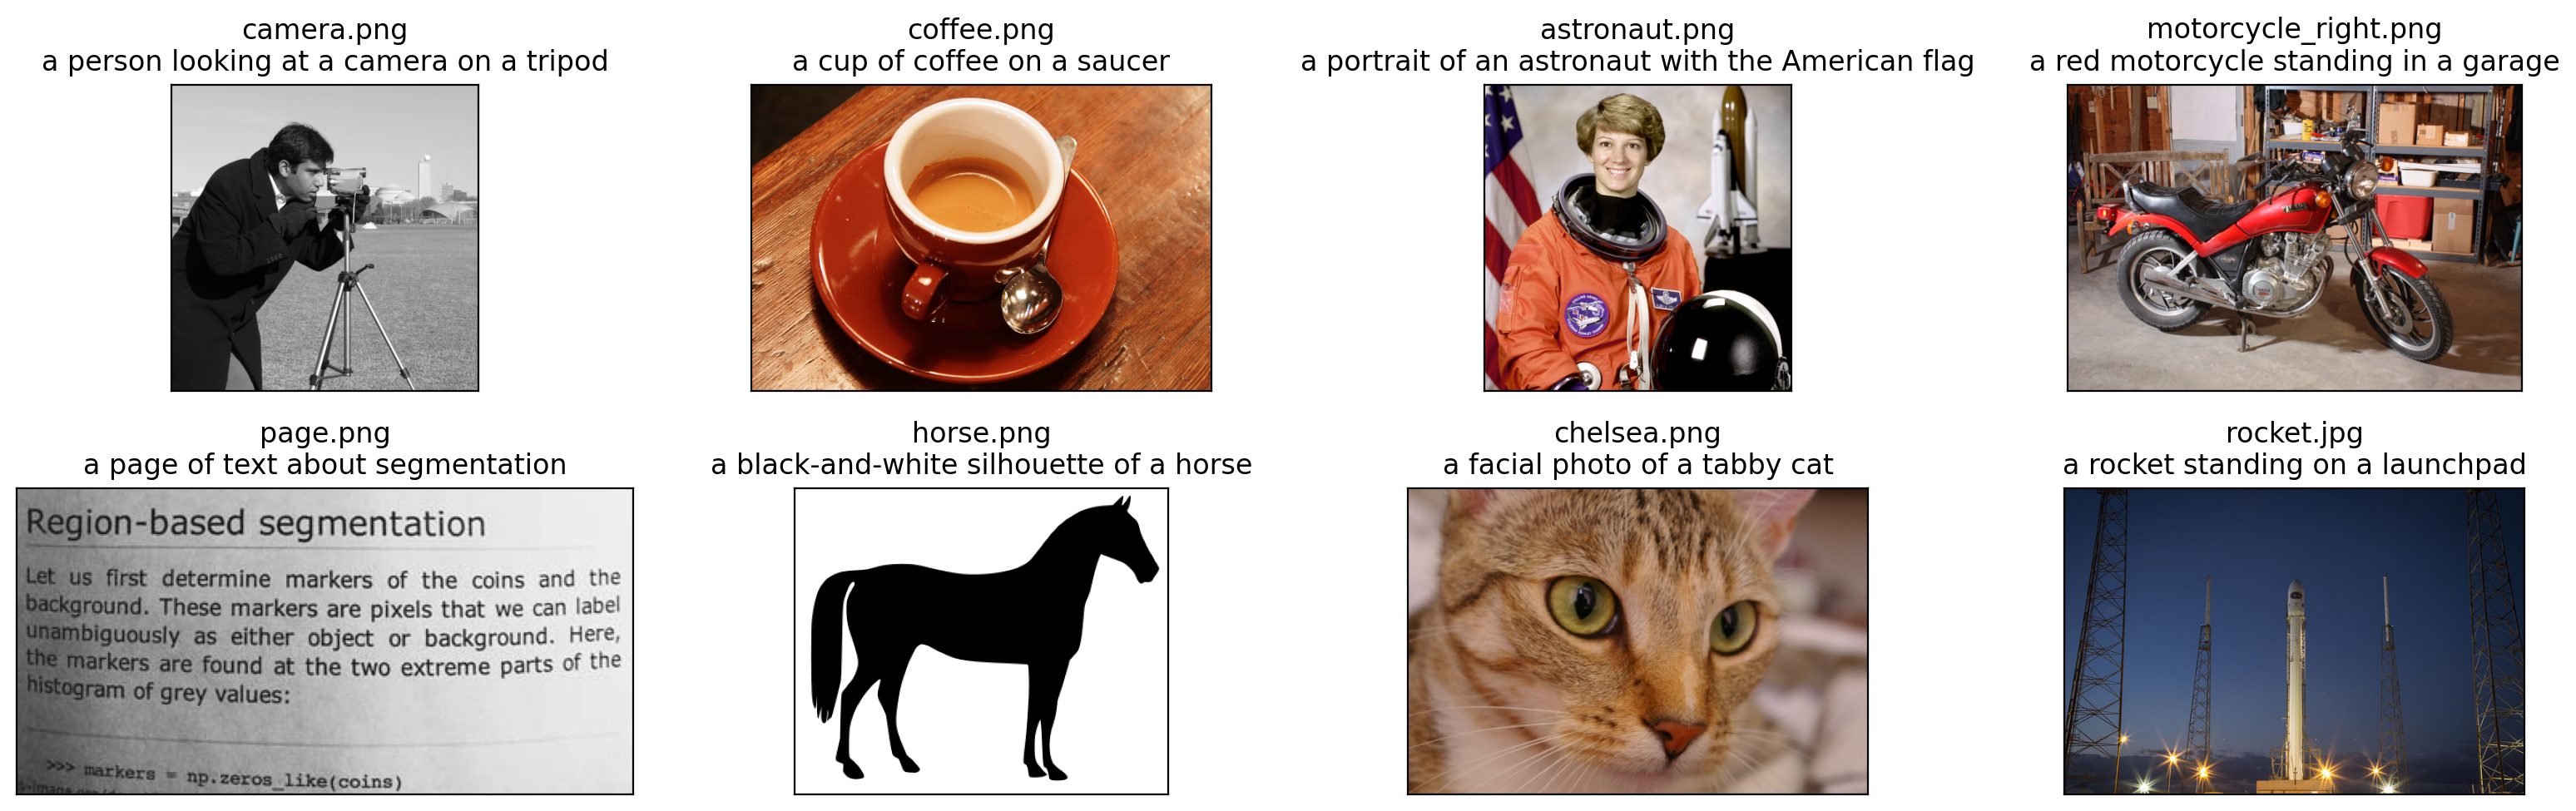

In [17]:
original_images = []
images = []
texts = []
plt.figure(figsize = (16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith('.png') or filename.endswith('.jpg')]:
  name = os.path.splitext(filename)[0]
  if name not in descriptions:
    continue

  image = Image.open(os.path.join(skimage.data_dir, filename)).convert('RGB')

  plt.subplot(2, 4, len(images) + 1)
  plt.imshow(image)
  plt.title(f"{filename}\n{descriptions[name]}")
  plt.xticks([])
  plt.yticks([])

  original_images.append(image)
  images.append(fe(image)['pixel_values'])
  texts.append(descriptions[name])

plt.tight_layout()

## feature 생성

이미지 정규화 & 각 텍스트 입력 토큰화 & 이미지와 텍스트 feature를 얻기 위해 모델의 forward pass 진행

In [18]:
image_input = fe(original_images, return_tensors = 'pt').to('cuda')
text_tokens = tokenizer(['This is ' + desc for desc in texts], return_tensors = 'pt', padding = True, max_length = 77).to('cuda')

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [19]:
with torch.no_grad():
  # 두 encoder를 위한 CLS token에 대한 출력 임베딩을 가짐.
  image_features = flava.get_image_features(**image_input)[:, 0].float()
  text_features = flava.get_text_features(**text_tokens)[:, 0].float()

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


## Cosine 유사도 계산

feature를 정규화하고 각 쌍의 내적을 계산한다.

In [20]:
image_features /= image_features.norm(dim = -1, keepdim = True)
text_features /= text_features.norm(dim = -1, keepdim = True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image feature')

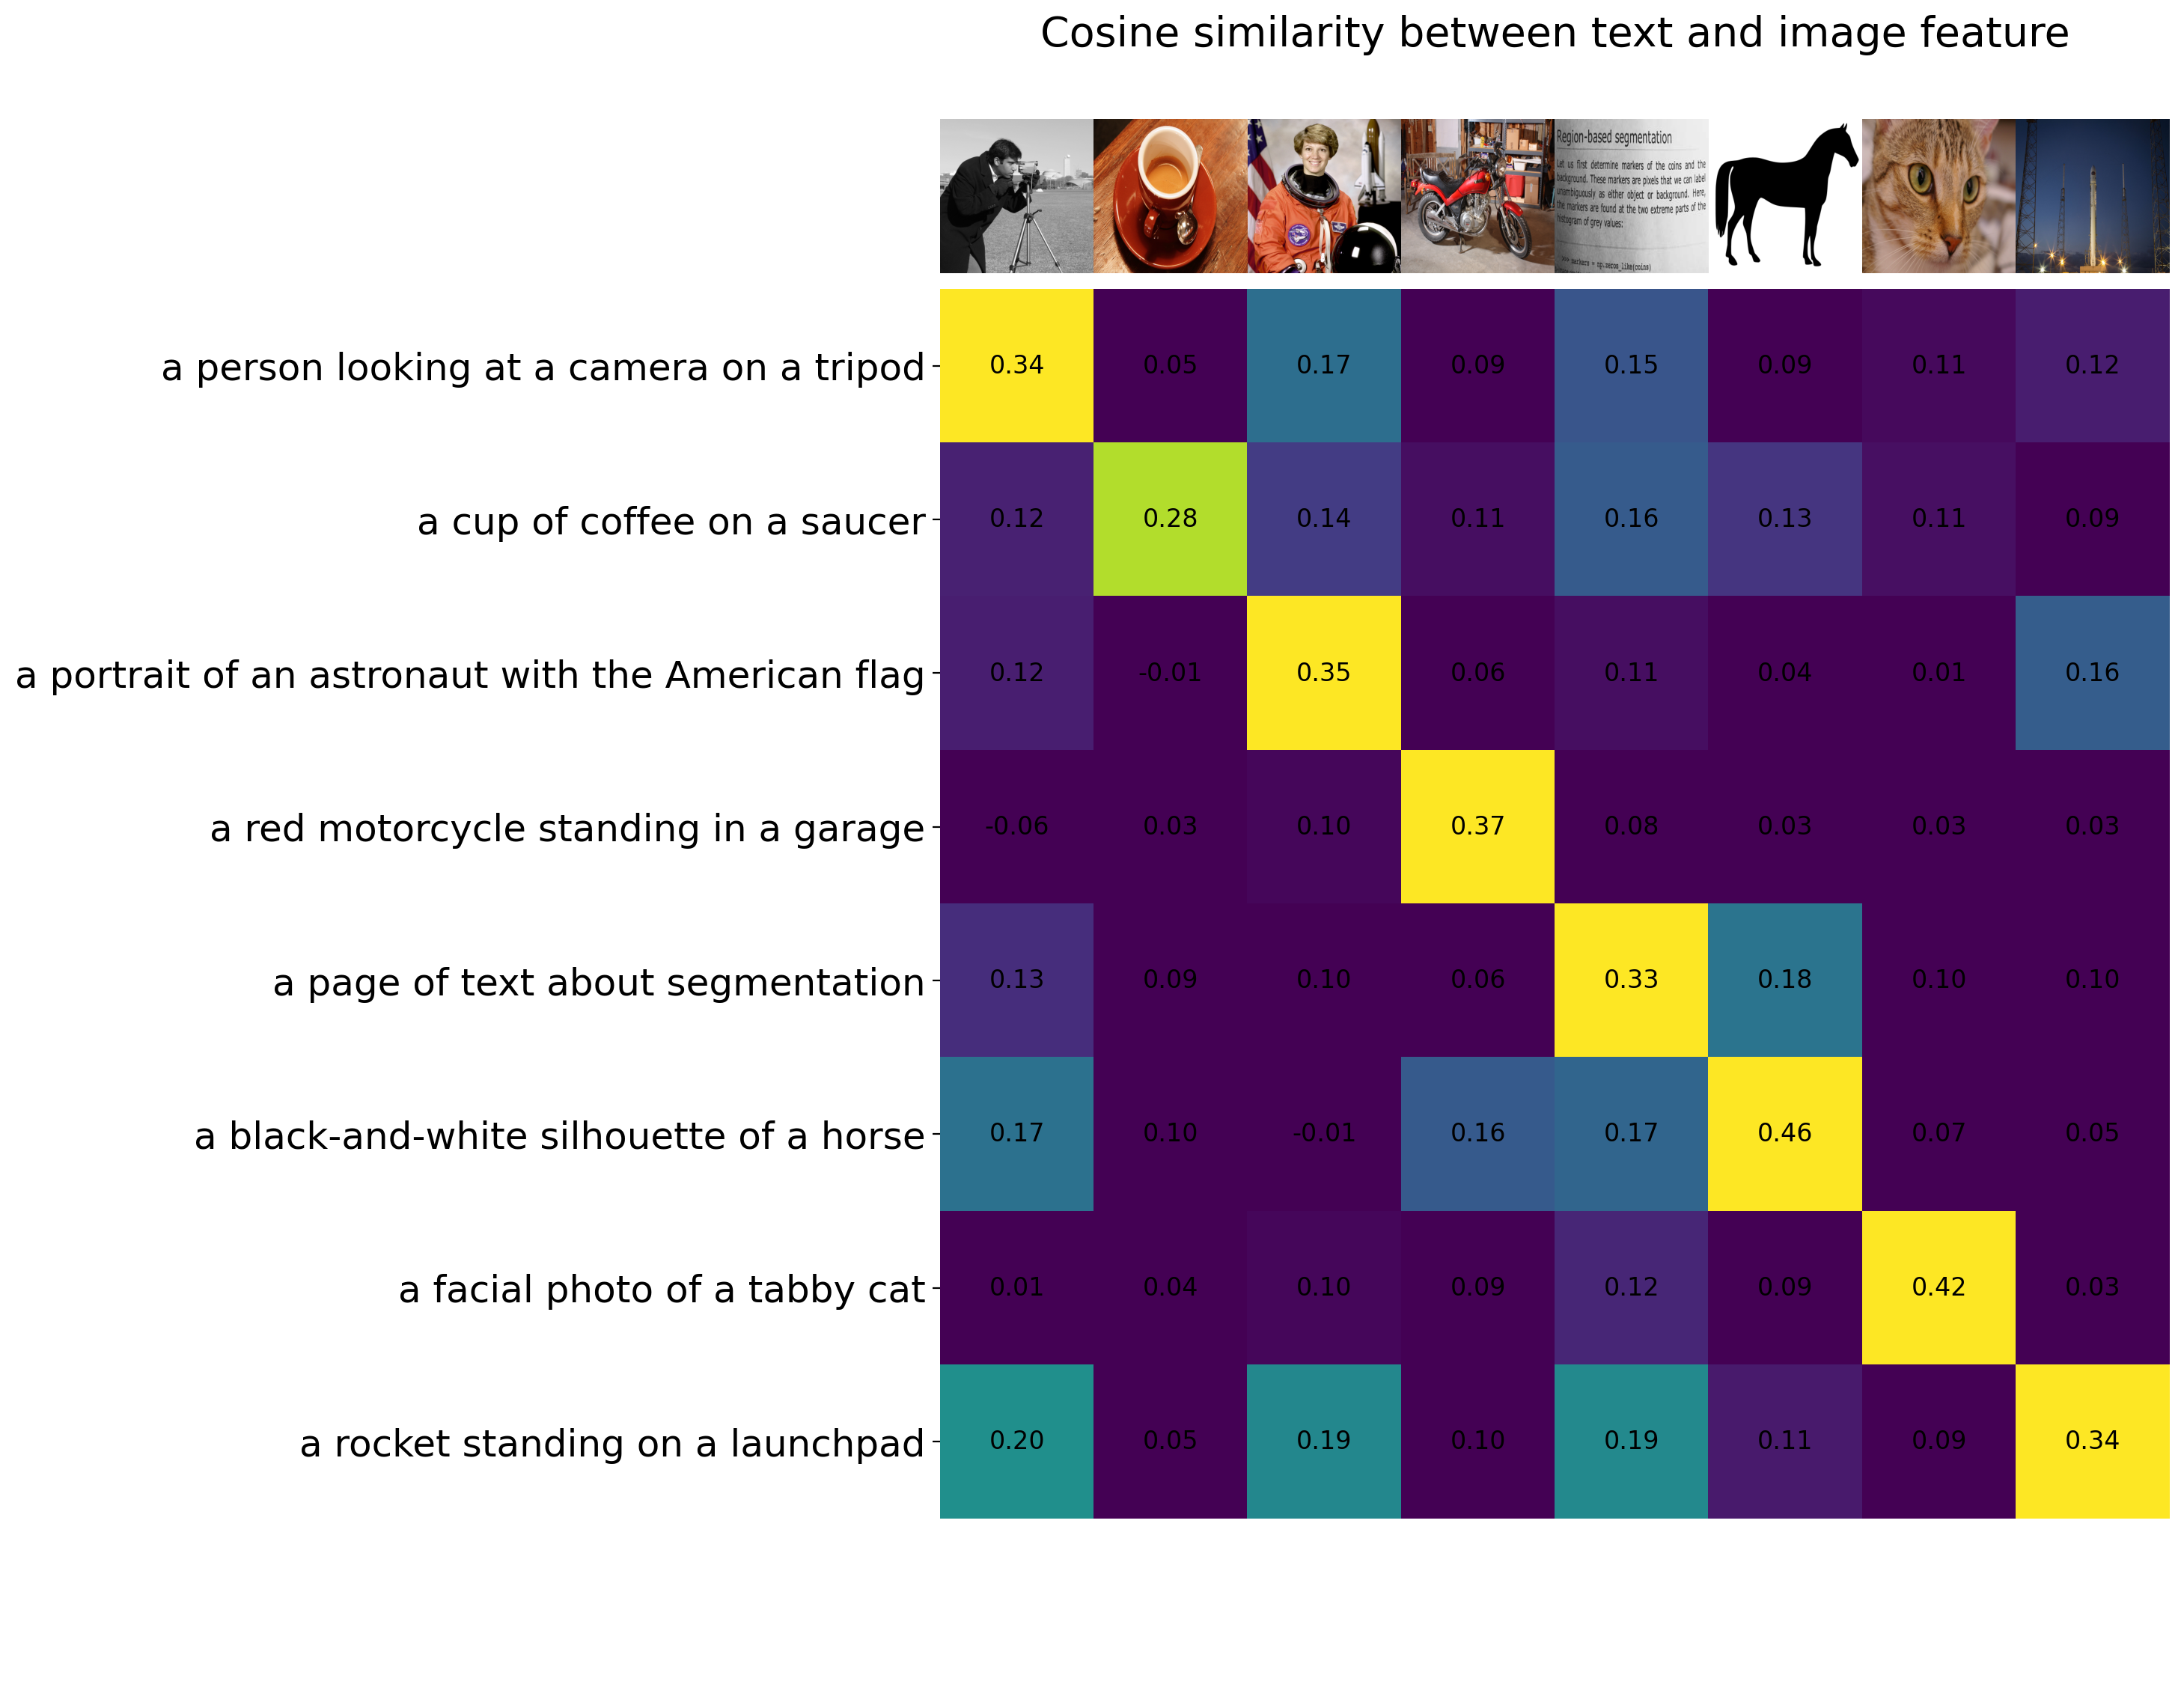

In [24]:
count = len(descriptions)

plt.figure(figsize = (20, 14))
plt.imshow(similarity, vmin = 0.1, vmax = 0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize = 18)
plt.xticks([])
for i, image in enumerate(original_images):
  plt.imshow(image, extent = (i - 0.5, i + 0.5, -1.6, -0.6), origin = 'lower')
for x in range(similarity.shape[1]):
  for y in range(similarity.shape[0]):
    plt.text(x, y, f"{similarity[y, x]:.2f}", ha = 'center', va = 'center', size = 12)

for side in ['left', 'top', 'right', 'bottom']:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim(count + 0.5, -2)

plt.title('Cosine similarity between text and image feature', size = 20)

## Zero-Shot Image Classification

코사인 유사도를 softmax 연사의 logit으로 사용하여 이미지를 분류할 수 있다.

In [26]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser('~/.cache'), download = True)

100%|██████████| 169001437/169001437 [00:03<00:00, 47766558.42it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [27]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer(text_descriptions, padding = True, max_length = 77, return_tensors = 'pt').to('cuda')

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [29]:
with torch.no_grad():
  text_features = flava.get_text_features(**text_tokens)[:, 0, :].float()
  text_features /= text_features.norm(dim = -1, keepdim = True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim = -1)
top_probs, top_labels = text_probs.cpu().topk(5, dim = -1)

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


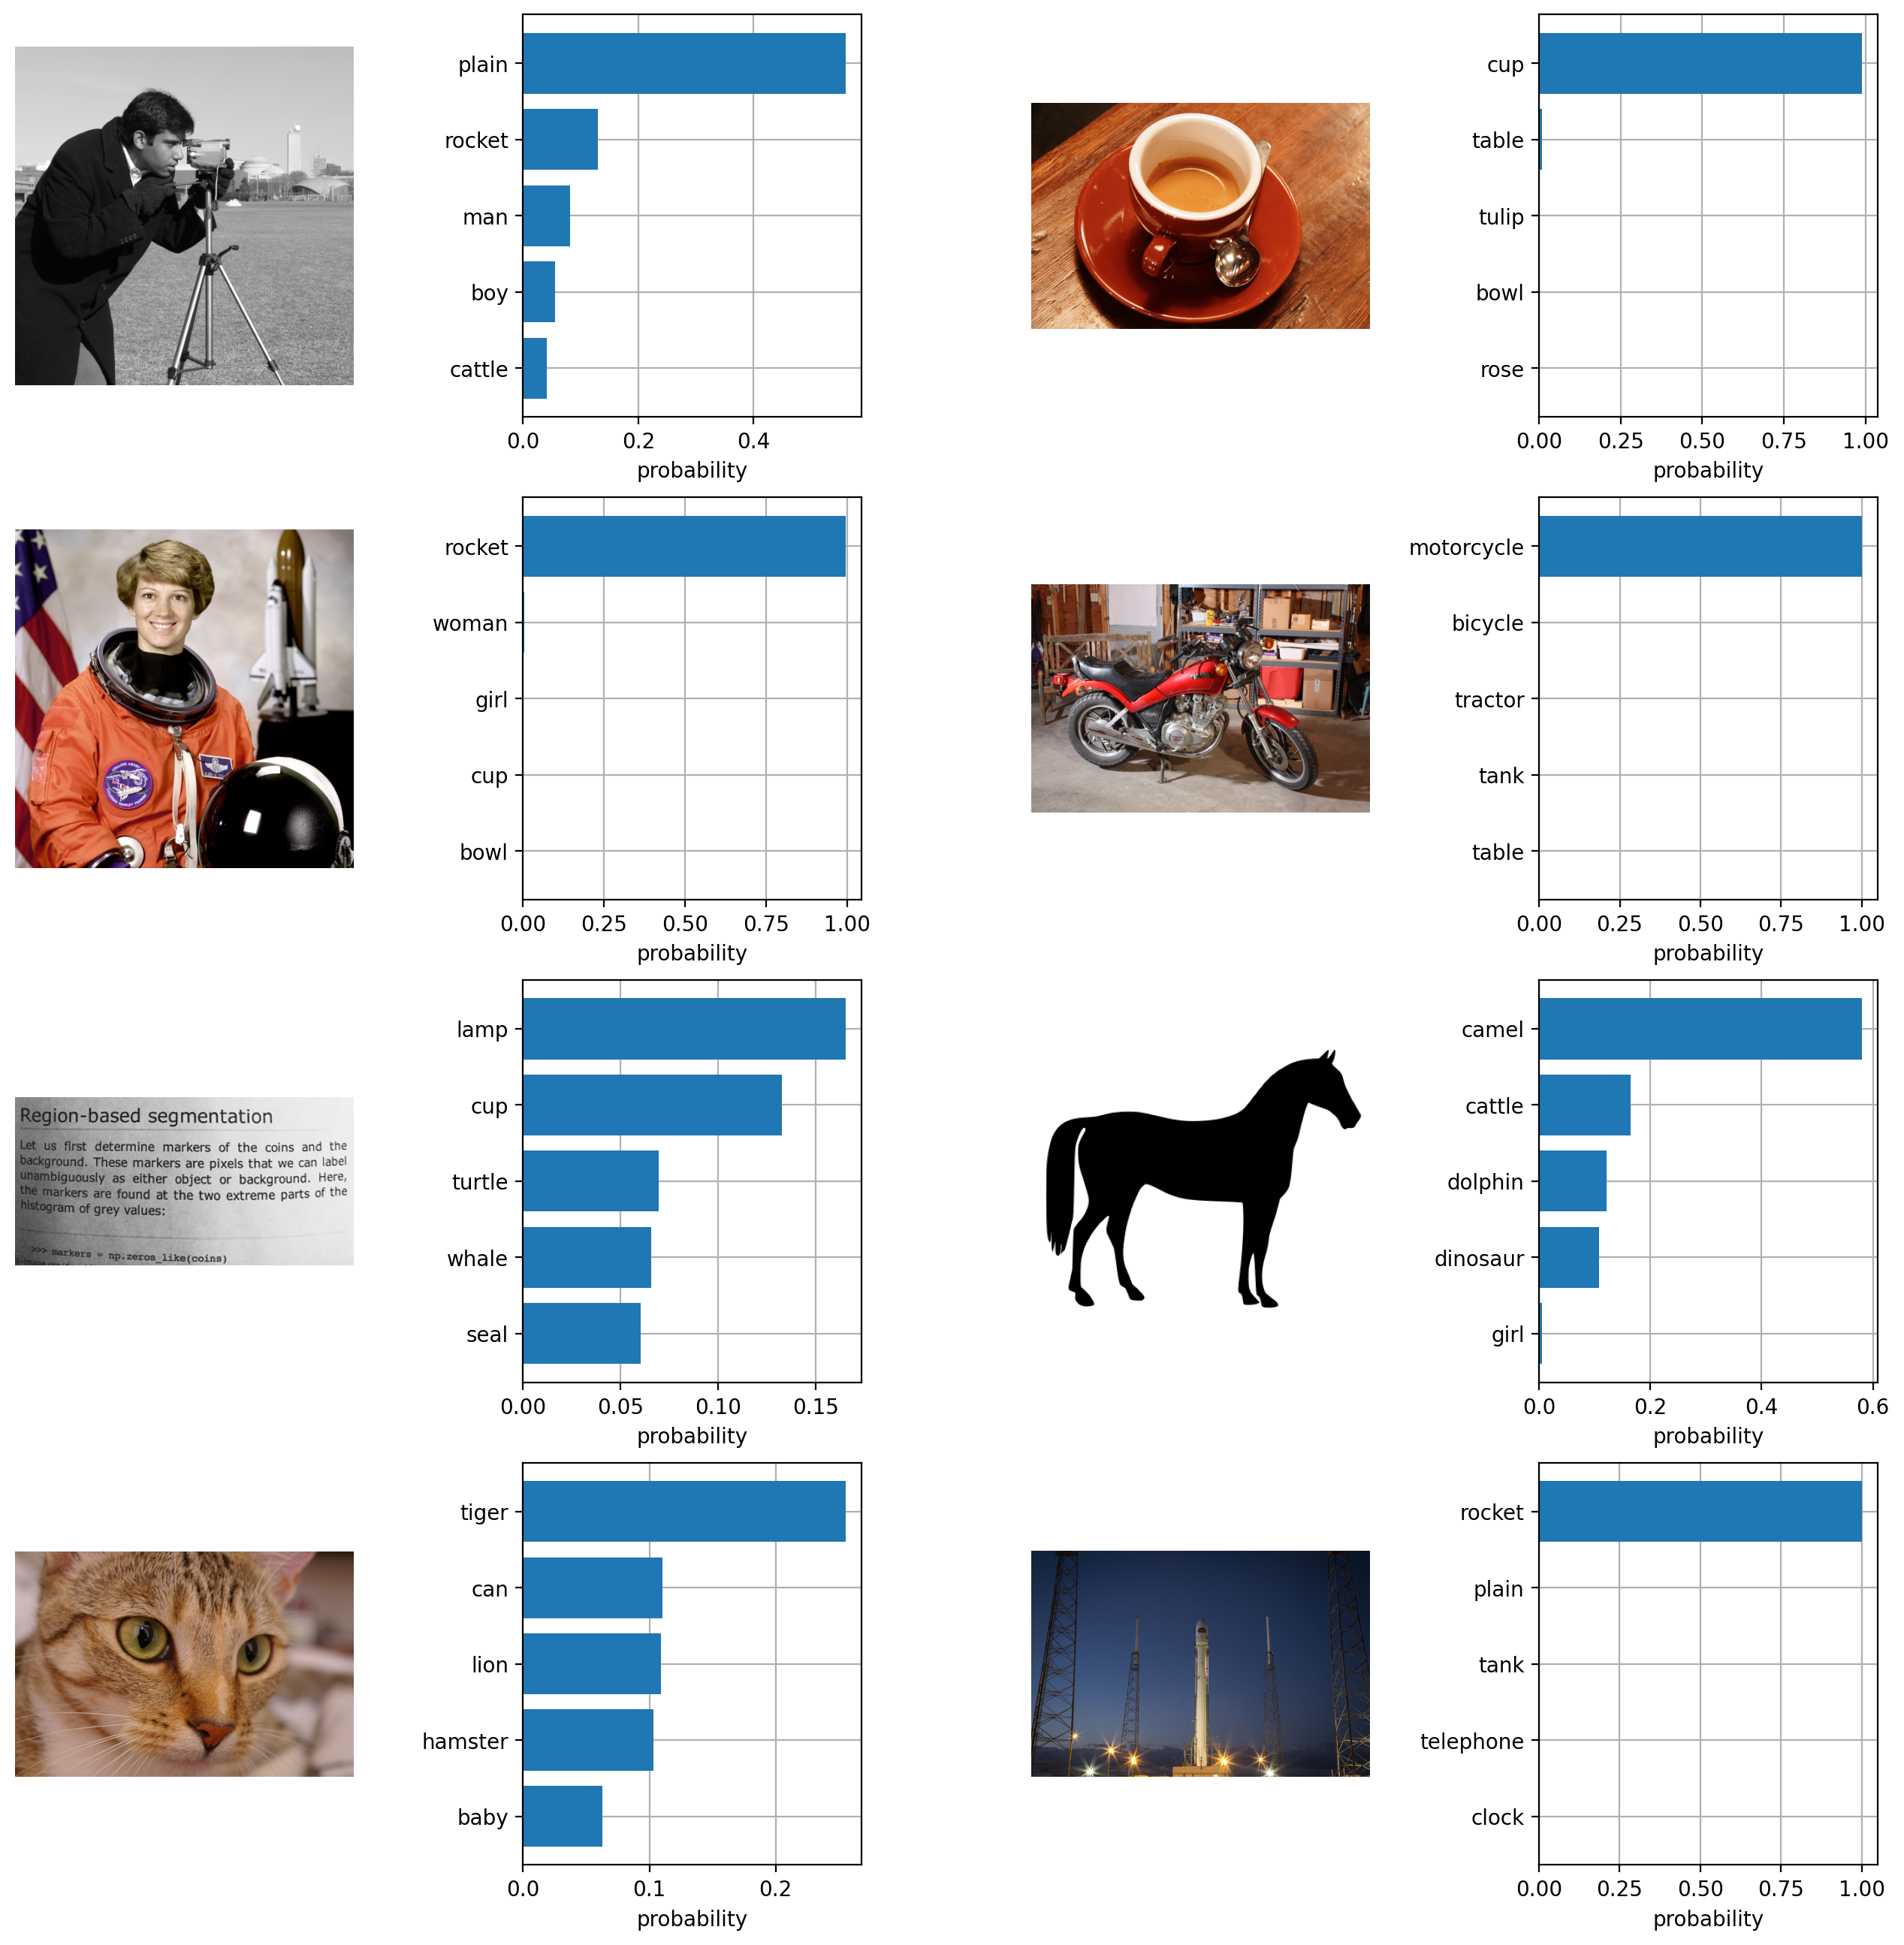

In [31]:
plt.figure(figsize = (16, 16))

for i, image in enumerate(original_images):
  plt.subplot(4, 4, 2 * i + 1)
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(4, 4, 2 * i + 2)
  y = np.arange(top_probs.shape[-1])
  plt.grid()
  plt.barh(y, top_probs[i])
  plt.gca().invert_yaxis()
  plt.gca().set_axisbelow(True)
  plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
  plt.xlabel('probability')

plt.subplots_adjust(wspace = 0.5)
plt.show()

솔직히 말해서 zero-shot image classification의 성능은 좋은지 잘 모르겠다. 아직은 살짝 엉뚱한 부분도 있는 것 같다. 몇몇 이미지에 대해서는 잘 분류하였지만, 이미지에서 중요한 부분이 아닌 다른 부분에 집중하거나 아니면 완전히 잘못된 분류를 보여주기도 하는 것 같다.